<a href="https://colab.research.google.com/github/edeery3/Stock_prediction/blob/main/GSK_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Preprocessing


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
gsk = pd.read_excel('/Stockdataset.xlsx', engine = 'openpyxl', sheet_name = 'GSK')

In [3]:
def convert_volume(val):
    val = str(val).strip().upper()
    if 'M' in val:
        return float(val.replace('M', '')) * 1000000
    elif 'K' in val:
        return float(val.replace('K', '')) * 1000
    elif val.replace('.', '', 1).isdigit():
        return float(val)
    else:
        return 0

In [4]:
gsk.isnull().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol.,1
Change %,0


In [5]:
gsk['Vol.'] = gsk['Vol.'].apply(convert_volume)

In [6]:
gsk.drop('Date', axis = 1).describe()

,Price,Open,High,Low,Vol.,Change %
count,2527.000000,2527.000000,2527.000000,2527.000000,2.527000e+03,2527.000000
mean,1516.391286,1516.399632,1530.648627,1502.953221,7.011167e+06,0.000068
std,137.163824,136.753475,137.508894,135.948140,3.590257e+06,0.013074
min,1202.780000,1213.080000,1227.620000,1202.780000,0.000000e+00,-0.100600
25%,1404.840000,1403.995000,1418.580000,1389.955000,4.820000e+06,-0.006750
50%,1510.550000,1511.800000,1525.400000,1496.510000,6.130000e+06,0.000100
75%,1625.495000,1624.380000,1638.575000,1611.070000,8.020000e+06,0.007100
max,1864.580000,1864.370000,1875.690000,1846.600000,4.366000e+07,0.076100


In [7]:
gsk['Date'] = pd.to_datetime(gsk['Date'])
gsk.set_index('Date', inplace=True)
gsk.sort_index(inplace=True)


In [8]:
gsk['SMA_30'] = gsk['Price'].rolling(window=30).mean()
gsk['Volatility_20'] = gsk['Price'].rolling(window=20).std()

In [9]:
train_start = '2015-04-01'
train_end = '2023-04-01'

# Use index-based slicing
train_gsk = gsk[train_start:train_end]
test_gsk = gsk[train_end:]

print(f"Train size: {len(train_gsk)}, Test size: {len(test_gsk)}")

Train size: 2022, Test size: 505


Exploratory Data Analysis Plots

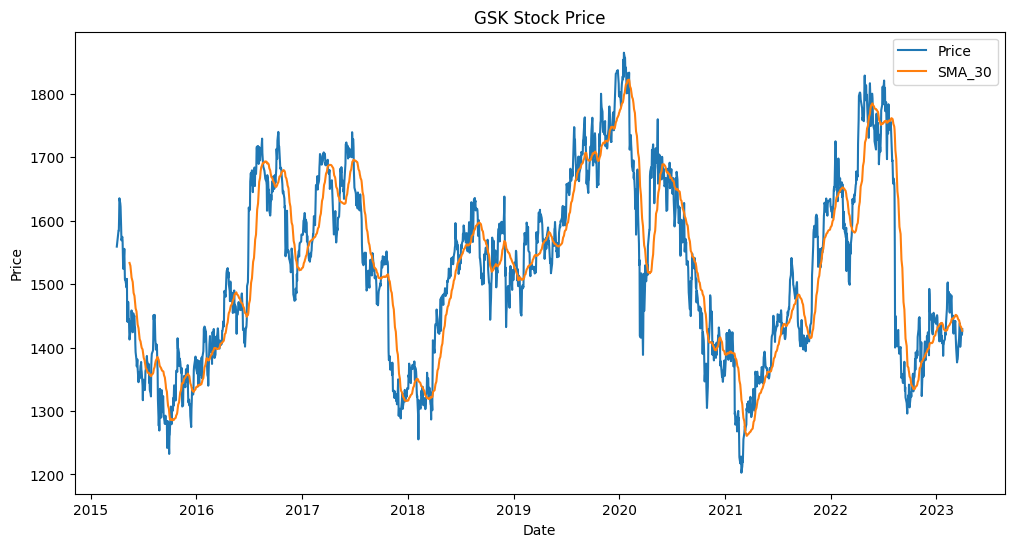

In [ ]:
plt.figure(figsize = (12,6))
plt.plot(train_gsk['Price'])
plt.plot(train_gsk['SMA_30'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Stock Price')
plt.legend(['Price', 'SMA_30'])
plt.show()

In [ ]:
fig = go.Figure(data=[go.Candlestick(
    open=train_gsk['Open'],
    high=train_gsk['High'],
    low=train_gsk['Low'],
    close=train_gsk['Price'],
    increasing_line_color='green',
    decreasing_line_color='red'
)])

fig.update_layout(title='GSK Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [10]:
gsk_mean = np.mean(train_gsk['Price'])
np.std(train_gsk['Price'])

140.93742878741486

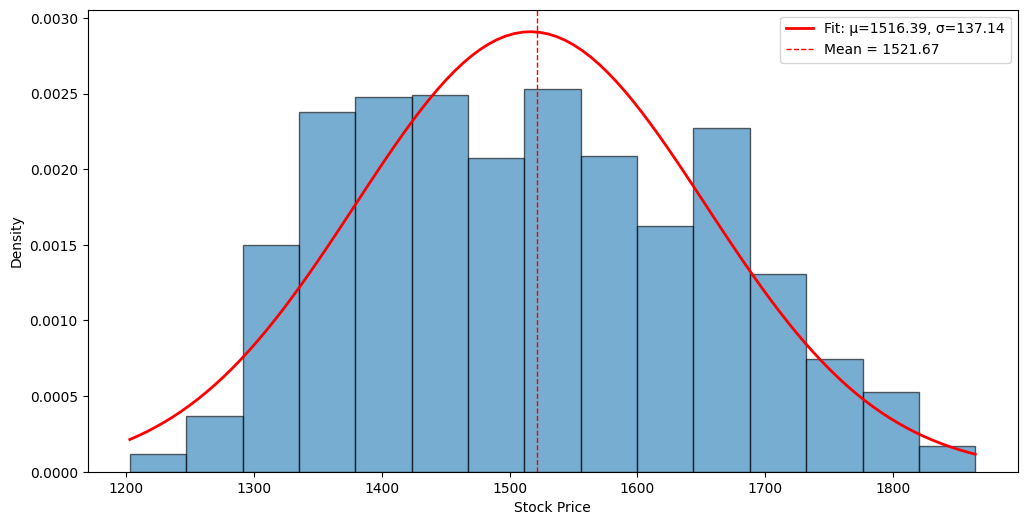

In [19]:
from scipy.stats import norm

mu, sigma = norm.fit(gsk['Price'])

# Plot histogram
plt.figure(figsize=(12, 6))
plt.hist(gsk['Price'], bins=15, density=True, alpha=0.6, edgecolor='black')

# Gaussian curve
x = np.linspace(min(gsk['Price']), max(gsk['Price']), 100)
p = norm.pdf(x, mu, sigma)
plt.plot(x, p, 'r', linewidth=2, label=f'Fit: μ={mu:.2f}, σ={sigma:.2f}')

# Mean Line
plt.axvline(gsk_mean, color='red', linestyle='--', linewidth=1, label=f'Mean = {gsk_mean:.2f}')


plt.xlabel("Stock Price")
plt.ylabel("Density")
plt.legend()
plt.show()


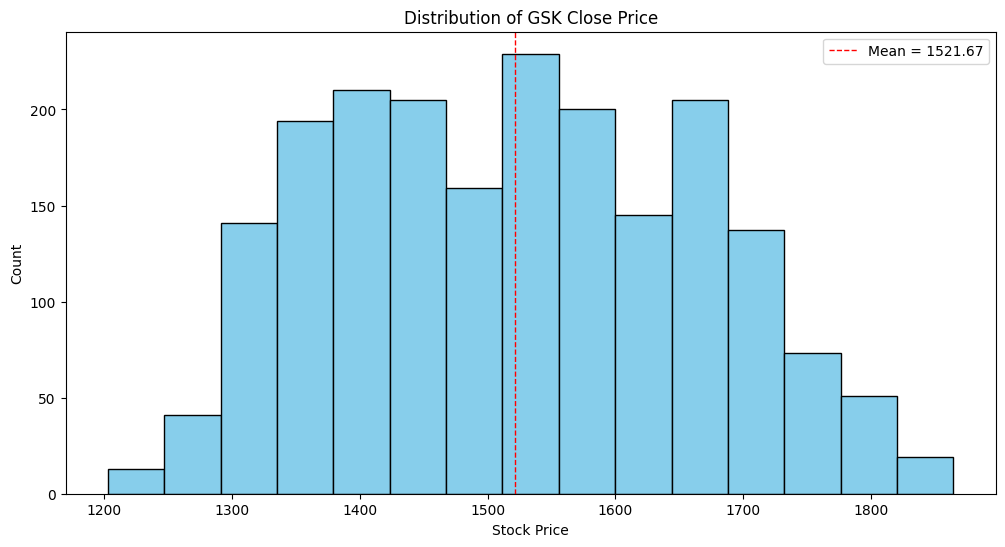

In [ ]:
plt.figure(figsize = (12,6))
plt.hist(train_gsk['Price'], bins = 15, lw = 2, edgecolor = 'black', color = 'skyblue')
plt.xlabel('Stock Price')
plt.ylabel('Count')
plt.title('Distribution of GSK Close Price')
plt.axvline(gsk_mean, color='red', linestyle='--', linewidth=1, label=f'Mean = {gsk_mean:.2f}')
plt.legend()

ARIMA

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis
import statsmodels.api as sm

In [ ]:
train_close = train_gsk['Price']
test_close = test_gsk['Price']

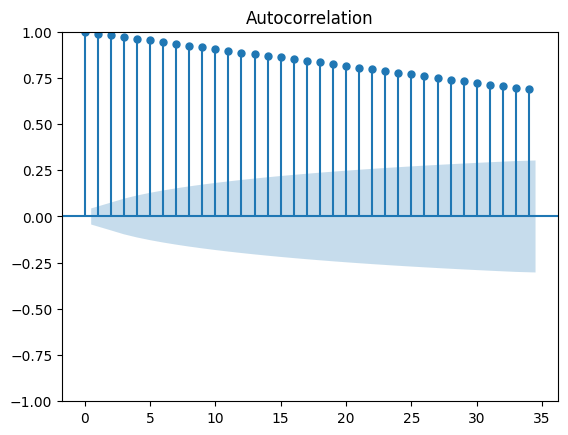

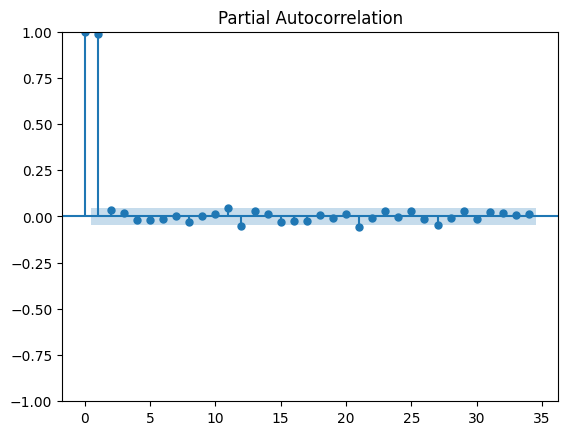

In [ ]:
plot_acf(train_close)
plot_pacf(train_close)
plt.show()

In [ ]:
result = adfuller(train_close)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.021990483292543
p-value: 0.03289117694360855


In [ ]:
train_close = train_close.asfreq(pd.infer_freq(train_close.index))
train_close = train_close.interpolate(method='linear')

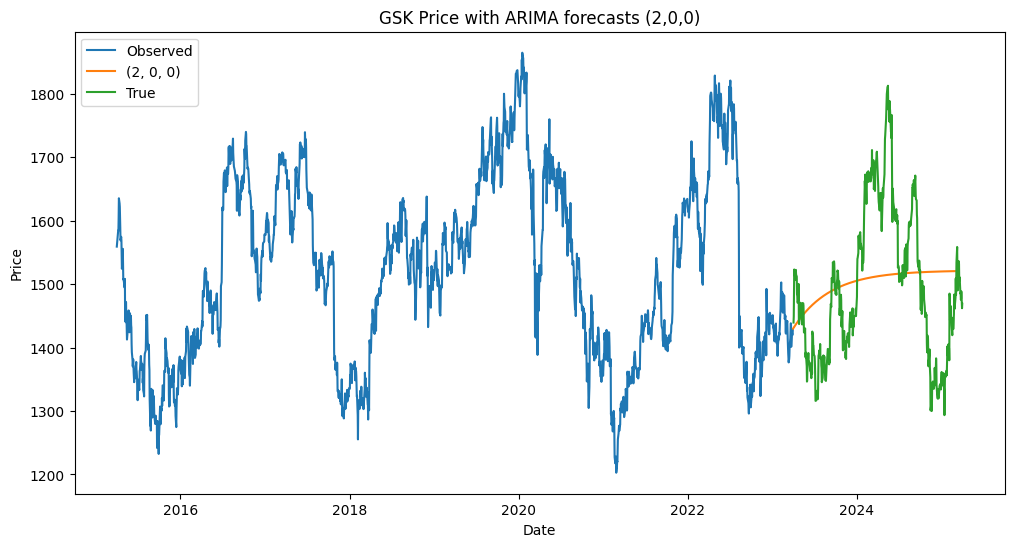

In [ ]:
# ARIMA fit
model = ARIMA(train_close, order=(2, 0, 0))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=700)

# Plot
plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 0, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts (2,0,0)')
plt.legend()
plt.show()

In [ ]:
results_list = []

for p in range(6):
    for d in range(3):
        for q in range(6):
                model = ARIMA(train_close, order=(p, d, q))
                fitted = model.fit()

                # Residuals and in-sample predictions
                resid = fitted.resid
                insample_pred = fitted.fittedvalues
                insample_actual = train_close[-len(insample_pred):]
                rmse_insample = np.sqrt(mean_squared_error(insample_actual, insample_pred))

                # Forecast on test set
                forecast = fitted.forecast(steps=len(test_close))
                rmse_outsample = np.sqrt(mean_squared_error(test_close, forecast))

                # AIC and BIC
                aic = fitted.aic
                bic = fitted.bic

                # Residual diagnostics
                if len(resid) > 10:
                    ljung_box_p = acorr_ljungbox(resid, lags=[10], return_df=True)['lb_pvalue'].iloc[0]
                    res_skew = skew(resid)
                    res_kurt = kurtosis(resid)
                else:
                    ljung_box_p = np.nan
                    res_skew = np.nan
                    res_kurt = np.nan

                # Store results
                results_list.append({
                    'order': (p, d, q),
                    'AIC': aic,
                    'BIC': bic,
                    'RMSE_in': rmse_insample,
                    'RMSE_out': rmse_outsample,
                    'LjungBox_p': ljung_box_p,
                    'Skewness': res_skew,
                    'Kurtosis': res_kurt
                })


# Convert to DataFrame
results_df = pd.DataFrame(results_list)

# Sort by out-of-sample RMSE
results_df = results_df.sort_values(by='RMSE_out')


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likel

In [ ]:
results_df = results_df.sort_values(by='AIC').reset_index(drop=True)

results_df.head()

,order,AIC,BIC,RMSE_in,RMSE_out,LjungBox_p,Skewness,Kurtosis
0,"(2, 1, 2)",24248.373511,24278.271917,32.662906,135.733830,9.964913e-01,37.121318,1772.553738
1,"(3, 1, 3)",24252.006798,24293.864567,32.662446,135.473710,9.976985e-01,37.124049,1772.648286
2,"(3, 1, 2)",24252.615153,24288.493241,32.664717,135.461010,9.978002e-01,37.116866,1772.159803
3,"(3, 2, 4)",24253.589345,24301.424057,35.679787,142.169370,4.801265e-60,24.966161,1320.655830
4,"(0, 1, 1)",24254.812129,24266.771491,32.678303,135.543852,9.983415e-01,37.070431,1769.224048


In [ ]:
results_df = results_df.sort_values(by='RMSE_out').reset_index(drop=True)

results_df.head()


,order,AIC,BIC,RMSE_in,RMSE_out,LjungBox_p,Skewness,Kurtosis
0,"(3, 0, 5)",24271.586850,24331.387086,15.350466,113.837889,0.968802,-0.537686,9.963490
1,"(3, 0, 4)",24269.547114,24323.367327,15.350282,113.838874,0.985132,-0.534753,9.958958
2,"(2, 0, 5)",24269.952238,24323.772451,15.351457,113.861594,0.945155,-0.540153,9.977434
3,"(4, 0, 5)",24272.577180,24338.357440,15.347648,113.882310,0.980208,-0.524653,9.980407
4,"(2, 0, 4)",24268.294208,24316.134397,15.352285,113.960666,0.931486,-0.545489,9.996153


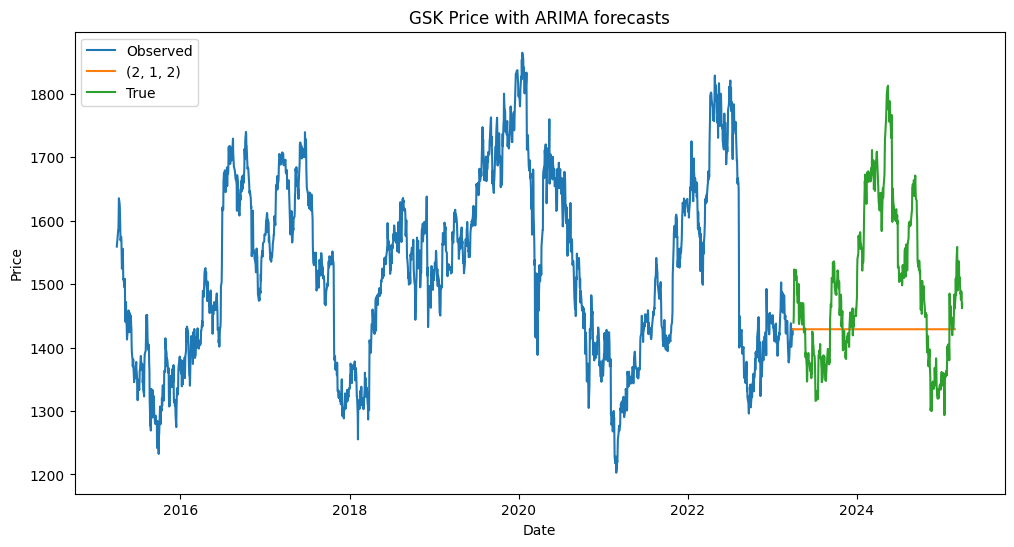

In [ ]:

model = ARIMA(train_close, order=(2, 1, 2))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 1, 2)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts')
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



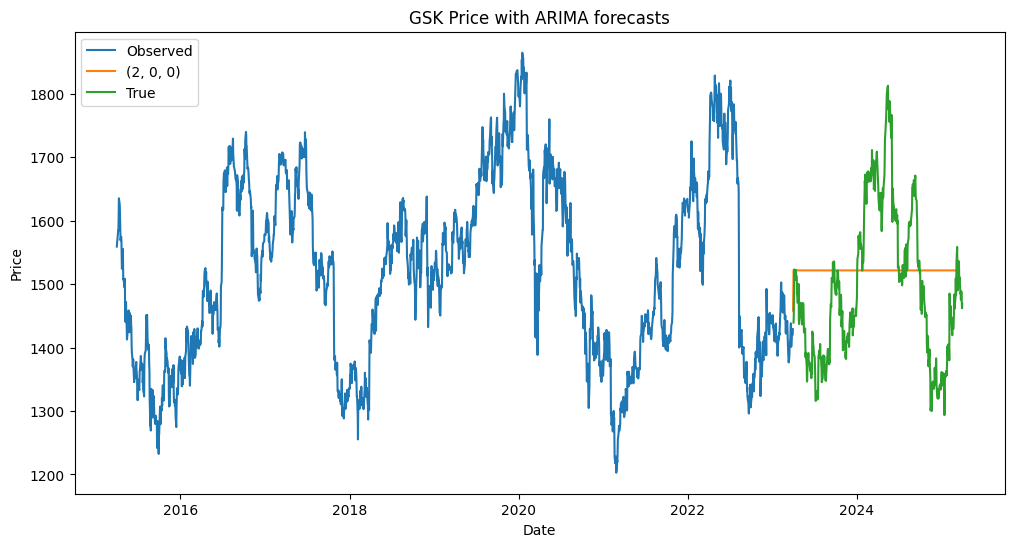

In [ ]:
model = ARIMA(train_close, order=(0, 0, 2))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(2, 0, 0)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts')
plt.legend()
plt.show()

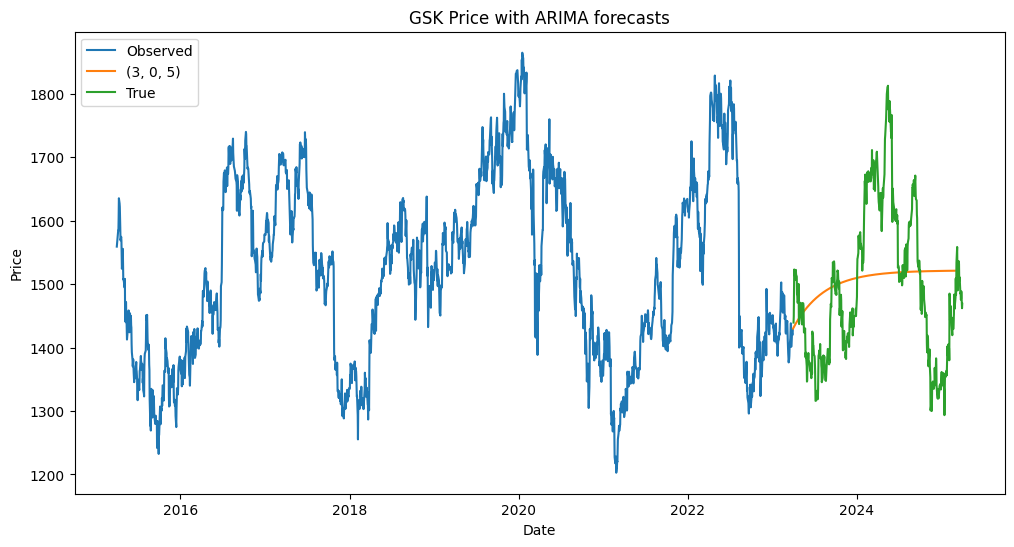

In [ ]:
model = ARIMA(train_close, order=(3, 0, 5))
model_fit = model.fit()

forecast = model_fit.forecast(steps=700)

plt.figure(figsize = (12,6))
plt.plot(train_close, label = 'Observed')
plt.plot(forecast, label = '(3, 0, 5)')
plt.plot(test_close, label = 'True')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('GSK Price with ARIMA forecasts')
plt.legend()
plt.show()

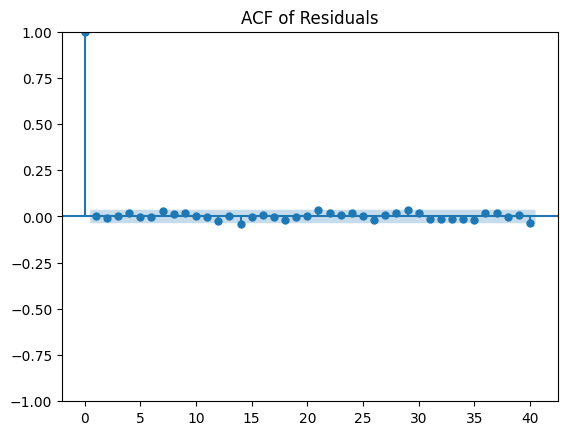

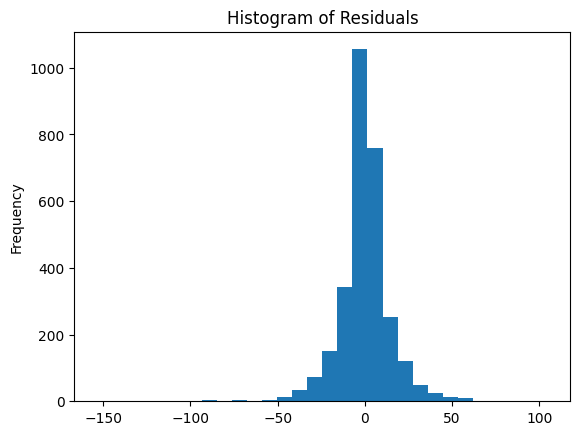

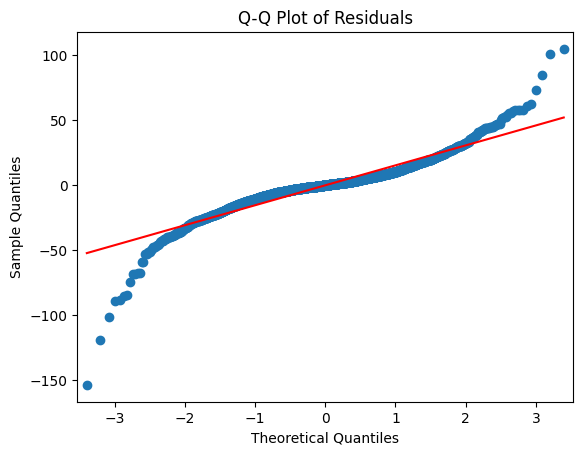

In [ ]:
model = ARIMA(train_close, order=(2, 0, 0))
model_fit = model.fit()


residuals = model_fit.resid

# ACF plot
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.show()

# Histogram
residuals.plot(kind='hist', bins=30, title='Histogram of Residuals')
plt.show()

# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

Rolling Forecast (5-step) RMSE: 31.16


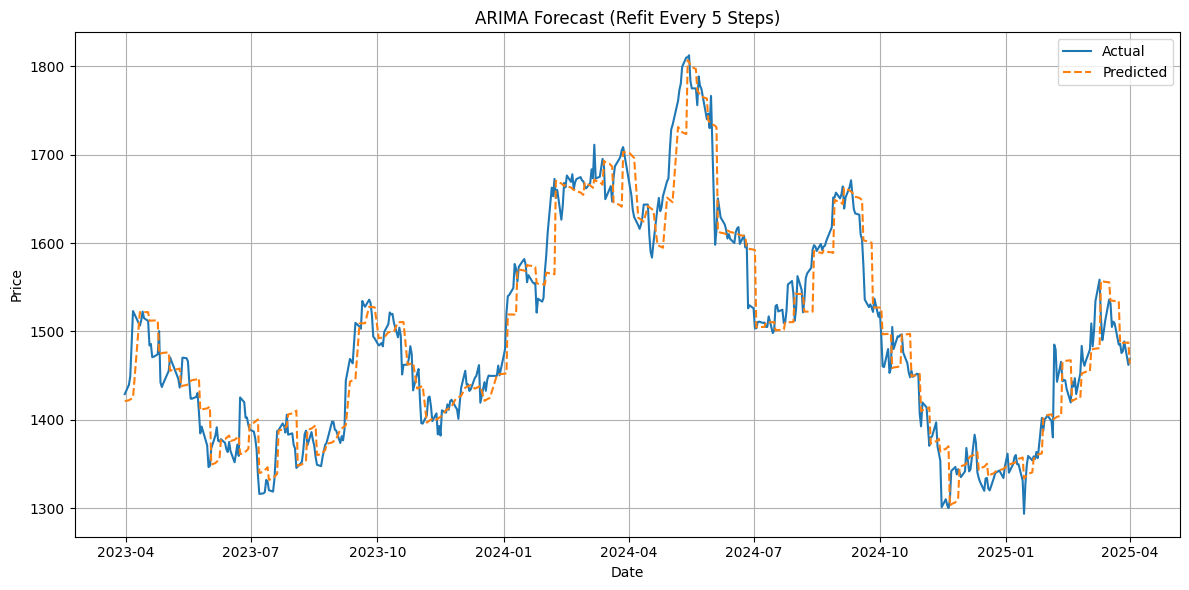

In [ ]:
data = gsk['Price'].values
dates = gsk.index

# Train/Test split
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]
train_dates, test_dates = dates[:train_size], dates[train_size:]

# Initialize
history = list(train)
history_dates = list(train_dates)
predictions = []
predicted_dates = []

step = 5
t = 0

while t < len(test):
    rolling = ARIMA(history, order=(2, 0, 0))
    rolling_fit = rolling.fit()

    end = min(t + step, len(test))
    forecast = rolling_fit.forecast(steps=end - t)

    # Apply to dates
    predictions.extend(forecast)
    predicted_dates.extend(test_dates[t:end])


    history.extend(test[t:end])
    history_dates.extend(test_dates[t:end])

    t = end

# Evaluation
predictions = predictions[:len(test)]
predicted_dates = predicted_dates[:len(test)]
rmse = np.sqrt(mean_squared_error(test, predictions))
print(f"Rolling Forecast (5-step) RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(12,6))
plt.plot(test_dates, test, label='Actual')
plt.plot(predicted_dates, predictions, label='Predicted', linestyle='--')
plt.title("ARIMA Forecast (Refit Every 5 Steps)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


LSTM

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.0710 - val_loss: 0.0050
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0065 - val_loss: 0.0046
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 72ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - loss: 0.0046 - val_loss: 0.0030
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0044 - val_loss: 0.0025
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0043 - val_loss: 0.0025
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - loss: 0.0038 - val_loss: 0.0025
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss:

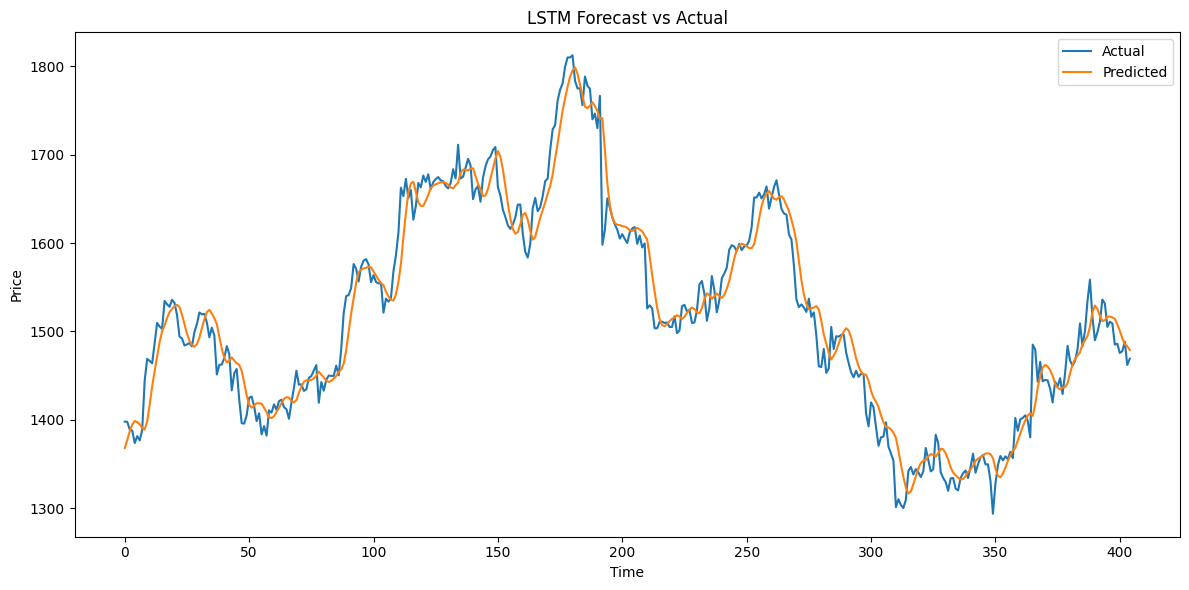

In [ ]:

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping


# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_close.values.reshape(-1, 1))
test_scaled = scaler.transform(test_close.values.reshape(-1, 1))


def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)


# Prepare sequences
n_steps = 100
X_train, y_train = create_sequences(train_scaled, n_steps)
X_test, y_test = create_sequences(test_scaled, n_steps)

# LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences = True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Predict
y_pred = model.predict(X_test)

# Inverse transform
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.title("LSTM Forecast vs Actual")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


MAE: 19.95, RMSE: 26.57


Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - loss: 0.0459
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0060
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - loss: 0.0054
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0050
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 0.0048
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0046
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 0.0040
Epoch 8/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0039
Epoch 9/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0037
Epoch 10/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0038
Epoch 11/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - loss: 0.0035
Epoch 12/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 82ms/step - loss: 0.0035
Epoch 13/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - loss: 0.0031
Epoch 14/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0028
Epoch 15/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - loss: 0.0

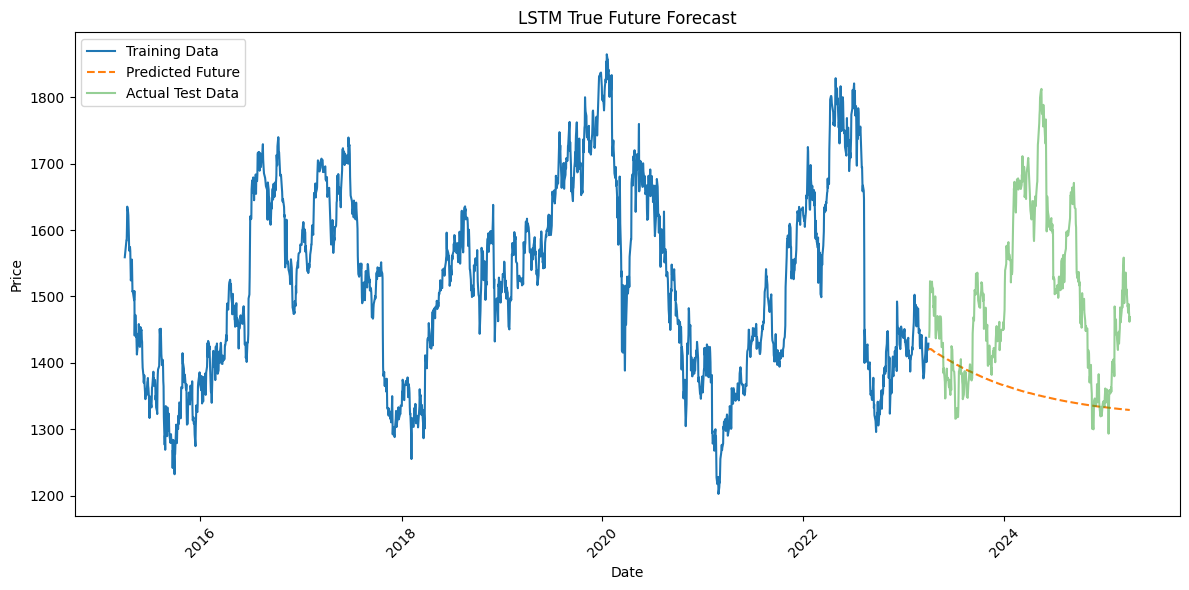

In [ ]:



# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_close.values.reshape(-1, 1))
test_scaled = scaler.transform(test_close.values.reshape(-1, 1))



# Sequence creation
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i - n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 100
X_train, y_train = create_sequences(train_scaled, n_steps)

# Build the LSTM model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Early Stopping
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Forecasting
def recursive_forecast(model, initial_sequence, n_steps_ahead):
    """
    Use predictions to create values at next time point
    """
    sequence = initial_sequence.copy()
    predictions = []

    for _ in range(n_steps_ahead):
        seq_reshaped = sequence.reshape((1, sequence.shape[0], sequence.shape[1]))
        pred_scaled = model.predict(seq_reshaped, verbose=0)
        pred = scaler.inverse_transform(pred_scaled)
        predictions.append(pred[0, 0])
        sequence = np.vstack((sequence[1:], pred_scaled))

    return np.array(predictions)


initial_seq = train_scaled[-n_steps:]
n_forecast = len(test_scaled)
future_preds = recursive_forecast(model, initial_seq, n_forecast)


all_dates = train_close.index.append(test_close.index)

plt.figure(figsize=(12,6))
plt.plot(train_close.index, train_close.values, label='Training Data')
plt.plot(test_close.index, future_preds, label='Predicted Future', linestyle='--')
plt.plot(test_close.index, test_close.values, label='Actual Test Data', alpha=0.5)
plt.title("LSTM True Future Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:

y_true = test_close.values.flatten()
y_pred = future_preds.flatten()

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 142.93, RMSE: 184.50
